Transfer learning allows us to take the patterns (parameters) that a model has learned from another problem and use them for our own problem. The advantage of doing that is, manyt models has already been trained using millions have data, therefore,
* Can save time training
* Just need to fine tune for our purpose
* Since trained on large data, can be more accurate than our case if we dont have a huge amounts of custom data for our problem.

Therefore, we need to use pretrained model whenever possible. First always check if a pretrained model can be used and if not present, build a model from scratch.

Commonly models are present in,
* https://huggingface.co/models
* torchvision.models
* https://paperswithcode.com/

In [15]:
import torch
import torchvision
from torchvision import transforms
from torchinfo import summary


import matplotlib.pyplot as plt
import os
import zipfile
from pathlib import Path
import requests

# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Get data

In [4]:
# data path
data_path = Path("../Dataset/")

# image path
img_path = data_path / "pizza_steak_sushi"

if img_path.is_dir():
    print("Folder already exists, skipping download ...")
else:
    print("Folder doesn't exist, creating one ...")
    
    # create image folder
    img_path.mkdir(parents=True)

    # download the data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading data ...")

        # write data
        f.write(request.content)

    # extract zip file
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as f:
        print("Unzipping the file ...")

        # extract file
        f.extractall(img_path)

    # delete zipfile
    os.remove(data_path / "pizza_steak_sushi.zip")

Folder already exists, skipping download ...


In [5]:
# Setup Dirs
train_dir = img_path / "train"
test_dir = img_path / "test"

# 2. Create dataset and dataloders
Since we are using a pretrained model, we need to transform our custom data in a way the data used for training the model was sent.
1. Resize image to 224X224
2. Images need to be normliased in range of [0,1] with mean = [0.485,0.456,0.406] and standard deviation = [0.229,0.224,0.225]. Three values since there are three channels. Will perform z-transform.
3. Convert image to tensor

In [8]:
from torchvision import transforms

# create a transform
transf = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.Normalize(mean = [0.485,0.456,0.406],
                            std= [0.229,0.224,0.225]),
    transforms.ToTensor()])

A better way to get the same transforms performed in the pretrained model is to use `torchvision.models` function. The trade-off of using this transforms is the lack of customisation.

In [12]:
# load an architecture
from torchvision.models import EfficientNet_B0_Weights

# get pretrained weigths
wts = EfficientNet_B0_Weights.DEFAULT # default : gives the best performance weights

# get the transforms used
transf_pretrained_model = wts.transforms()
transf_pretrained_model

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
# create dataset and dataloaders using created function
from turning_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataset_dataloader(train_dir=train_dir, test_dir=test_dir,
                                                                                      transform=transf, 
                                                                                      batch_size=32) # mini-batch of 32
class_names

['pizza', 'steak', 'sushi']

In [14]:
# create dataset and dataloaders using pretrained transforms
from turning_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataset_dataloader(train_dir=train_dir, test_dir=test_dir,
                                                                                      transform=transf_pretrained_model, 
                                                                                      batch_size=32) # mini-batch of 32
class_names

['pizza', 'steak', 'sushi']

# 3. Getting pretrained model
As we saw in `04` and `05` notebooks that our model performance was relatively poor. That's why we are leveraging transfer learning. The better performing model may sometimes be `too big` on some devices. eg:mobile devices, therefore some trade-off needs to be there.

Therefore, there will always be a,
**performance vs speed vs size tradeoff**

`EfficientNet_B0_Weights` is the model we are going to be using in our case. Other model performance can be checked by experimentation.

In [16]:
wts = EfficientNet_B0_Weights.DEFAULT # default : gives the best performance weights

# sending the weights to the model
model = torchvision.models.efficientnet_b0(weights=wts).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\AJIN RUFUS/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:03<00:00, 6.64MB/s]


In [26]:
from torchinfo import summary

summary(model, input_size=(32,3,224,224), col_width=20,
       col_names=["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param #              Trainable
EfficientNet                                            [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential: 1-1                                       [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]   [32, 16, 112, 112]   --                   True
│    

# 4. Freezing base mode and changing the output layer

Since the output layer is problem specific, it needs to be altered. This is done by `freezing base layers` and then `adjust output layers` (also called head/classifier layer) to suit our need.

The model above comes with `1000` output classes since there are 1000 classes in imageNet. For our classification,we need only `3` output classes.

1. Freeze all the layers (set it to untrainable) - set `requirees_grad` to `False`

In [33]:
# freeze all the parameters except classifier layer
for param in model.features.parameters(): # get parameters of each layer
    param.requires_grad = False

summary(model, input_size=(32,3,224,224), col_width=20,
       col_names=["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param #              Trainable
EfficientNet                                            [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]   [32, 16, 112, 112]   --                   Fal

In [34]:
# change the output layer (classifier layer)
torch.manual_seed(42)

# out classes size
n_out_classes = len(class_names)

from torch import nn
# create the classifier layer
model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True), # keep the dropout as was in original classifier layer
                                 nn.Linear(in_features=1280,
                                           out_features=n_out_classes,
                                           bias=True)).to(device)

# 5. Training and tracking
Previously we were tracking the experiment results using `dictionaries`, so now we need to tune our `train()` function inorder to use `torch.utils.tensorboard.SummaryWriter()` which saves various parts of our model's training progress to file (log). This is saved in `tensorBoard format`.

In [37]:
# create loss functio nadn optimiser
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
# use created train function
from turning_modular import engine

torch.manual_seed(42)

results = engine.train(model=model, train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader, optimizer=optim,
                       loss_fn=loss_fn, epochs=5, device=device)

 20%|████████████████▊                                                                   | 1/5 [00:20<01:22, 20.53s/it]

Model: EfficientNet | train loss: 1.0962 | Train acc: 39.0625%
Model: EfficientNet | Test loss: 0.9144, test accuracy: 59.09090909090909% 



 40%|█████████████████████████████████▌                                                  | 2/5 [00:37<00:56, 18.68s/it]

Model: EfficientNet | train loss: 0.8708 | Train acc: 76.9531%
Model: EfficientNet | Test loss: 0.7918, test accuracy: 84.56439393939394% 



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:56<00:37, 18.54s/it]

Model: EfficientNet | train loss: 0.7686 | Train acc: 79.2969%
Model: EfficientNet | Test loss: 0.7461, test accuracy: 83.52272727272727% 



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:13<00:18, 18.10s/it]

Model: EfficientNet | train loss: 0.7167 | Train acc: 74.2188%
Model: EfficientNet | Test loss: 0.6370, test accuracy: 87.59469696969695% 



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:31<00:00, 18.23s/it]

Model: EfficientNet | train loss: 0.6291 | Train acc: 76.9531%
Model: EfficientNet | Test loss: 0.6272, test accuracy: 89.6780303030303% 



We can see that we are able to get model accuracy almost `triple` that of what we got using the `TinyVGG` model.

In [39]:
results

{'train_loss': [1.0961915254592896,
  0.8707624077796936,
  0.768615186214447,
  0.7166786789894104,
  0.6291415691375732],
 'train_acc': [39.0625, 76.953125, 79.296875, 74.21875, 76.953125],
 'test_loss': [0.914383331934611,
  0.7918137709299723,
  0.7461126645406088,
  0.6369520028432211,
  0.6271932125091553],
 'test_acc': [59.09090909090909,
  84.56439393939394,
  83.52272727272727,
  87.59469696969695,
  89.6780303030303]}

# 6. Model Evaluation
We will plot the loss curve to evaulate the model performance

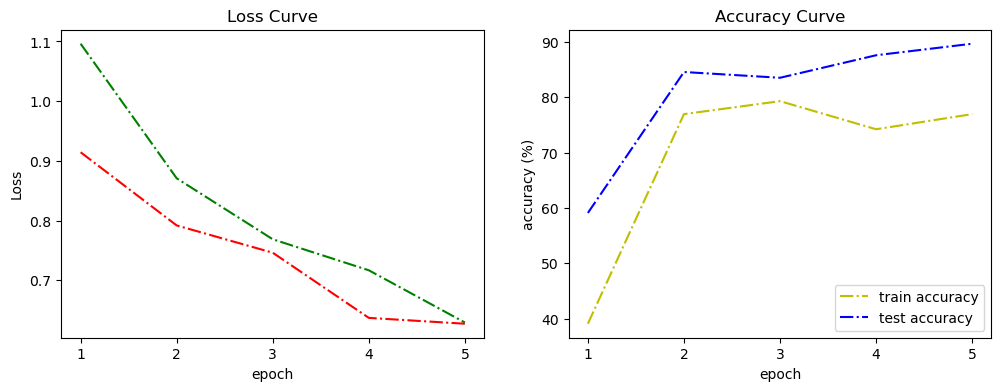

In [82]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

epochs = 5

# plot model loss
ax[0].plot(range(1,epochs+1), results["train_loss"], "g-.", label="train loss")
ax[0].plot(range(1,epochs+1), results["test_loss"], "r-.", label="test loss")

ax[0].set_title("Loss Curve")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Loss")

# custom xticks
ax[0].set_xticks(range(1, epochs+1))

# plot model accuracy
ax[1].plot(range(1,epochs+1), results["train_acc"], "y-.", label="train accuracy")
ax[1].plot(range(1,epochs+1), results["test_acc"], "b-.", label="test accuracy")

ax[1].set_title("Accuracy Curve")
ax[1].set_xticks(range(1, epochs+1))

ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy (%)")

plt.legend()
plt.show()

We can see that both loss and accuracy are headin towards the right direction and also we can see since,
* Training and testing accuracy or loss is decreasing with epoch and is able to achieve a good value, model is not `underfitting`.
* Since testing accuracy doesn't decrease with epoch, the model is not `overfitting` as well.

# 7. Make predictions
We will make prediction using an image I captured while eating pizza. The steps to be followed are,

1. Perform transformation
2. Usual testing

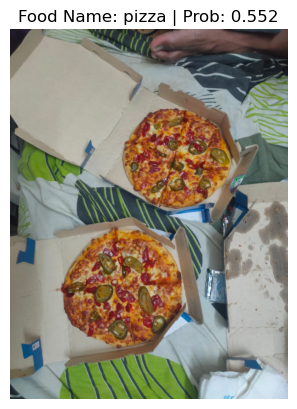

In [104]:
from PIL import Image

# open image
img = Image.open(data_path / "pizza_test_dominos.jpg")

# transformation
img_transf = transforms.Compose([transforms.Resize(size=(224,224)),
                                 transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

# predict the image

# make sure model is in target device
model.to(device)

# put in evaluation and inference mode
model.eval()
with torch.inference_mode():

    # transformed image
    transformed_image = img_transf(img).unsqueeze(dim=0) # since expects to be in batches

    # prediction
    img_pred = model(transformed_image.to(device))

    # logits -> probability
    img_prob = torch.softmax(img_pred, dim=1)

    # probability -> prediction label
    img_label = torch.argmax(img_prob, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Food Name: {class_names[img_label]} | Prob: {img_prob.max():.3f}")
    plt.axis(False);

# Conclusion:
We are able to make a correct prediction with good confidence using the model used. This can be verified using other custom datasets as well.